In [2]:
from helper_shapley_sampling import *
from helper_indep import *
from helper import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from sklearn.linear_model import LogisticRegression


In [3]:
dirpath = "../Data/bank"
# dirpath = /PATH/TO/DATA
df_orig = pd.read_csv(join(dirpath, "df_orig.csv"))

X_train_raw = np.load(join(dirpath, "X_train.npy"))
X_test_raw = np.load(join(dirpath, "X_test.npy"))
y_train = np.load(join(dirpath, "Y_train.npy"))
y_test = np.load(join(dirpath, "Y_test.npy"))
full_dim = X_train_raw.shape[1] # dimension including all binarized categorical columns
X_df = pd.read_csv(join(dirpath, "X_df.csv"))


trainmean, trainstd = np.mean(X_train_raw, axis=0), np.std(X_train_raw, axis=0)
def rescale(x, trainmean, trainstd):
    return (x - trainmean) / trainstd
X_train = rescale(X_train_raw, trainmean, trainstd)
X_test = rescale(X_test_raw, trainmean, trainstd)

feature_means = np.mean(X_train, axis=0)
cov_mat = np.cov(X_train, rowvar=False)


df_orig.columns = df_orig.columns.str.replace(' ', '_')
categorical_cols = ['Job', 'Marital', 'Education', 'Default', 'Housing',
                    'Loan', 'Contact', 'Month', 'Prev_Outcome']
mapping_dict = get_mapping_dict(df_orig, X_df, X_train_raw, categorical_cols)
mapping_dict

d = X_df.shape[1]


In [4]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Class imbalance: {}".format(100*(max(np.mean(y_test), 1-np.mean(y_test)))))
print("Estimation accuracy: {}".format(np.mean((logreg.predict(X_test) > 0.5)==y_test)*100))

xloc = X_test[0:1]
def fmodel(xloc):
    return logreg.predict_proba(xloc)[:,1]

BETA = logreg.coef_.reshape(-1)
gradient = logreg_gradient(fmodel, xloc, BETA)
hessian = logreg_hessian(fmodel, xloc, BETA)


Class imbalance: 88.29904888299049
Estimation accuracy: 90.22340190223403


In [5]:
independent_features = True
shap_CV_true_indep = compute_true_shap_cv_indep(xloc, gradient, hessian, feature_means, cov_mat, mapping_dict=mapping_dict)
M = 1000

### Feature index 13 is the biggest

In [6]:
np.random.seed(1)
obj_ss = cv_shapley_sampling(fmodel, X_train, xloc, 
                        independent_features,
                        gradient, hessian,
                        mapping_dict=mapping_dict,
                        M=100, n_samples_per_perm=10) # M is number of permutations
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_ss

order = np.argsort(np.abs(final_ests))[::-1]
j = order[0]
print(j)

13


In [7]:
# obj_ss = cv_shapley_sampling_j(fmodel, X_train, xloc, j,
#                             independent_features,
#                             shap_CV_true_indep[j],
#                             gradient, hessian,
#                             mapping_dict=mapping_dict,
#                             M=M, n_samples_per_perm=10,
#                             return_vars=True)
# vars = obj_ss[4]
# vars_vanilla_model = vars[0,:]
# vars_CV_model = vars[1,:]
# start_idx = 200
# plt.plot(np.arange(start_idx, M), np.log10(vars_CV_model[start_idx:]))
# plt.plot(np.arange(start_idx,M), np.log10(vars_vanilla_model[start_idx:]))

In [12]:
%run helper_shapley_sampling
np.random.seed(1)
vars_vanilla_model_all, vars_CV_model_all = [], []
for _ in range(50):
    obj_ss = cv_shapley_sampling_j(fmodel, X_train, xloc, j,
                            independent_features,
                            shap_CV_true_indep[j],
                            gradient, hessian,
                            mapping_dict=mapping_dict,
                            M=M, n_samples_per_perm=10,
                            return_vars=True)
    
    vars_vanilla_model_all.append(obj_ss[4][0,:])
    vars_CV_model_all.append(obj_ss[4][1,:])

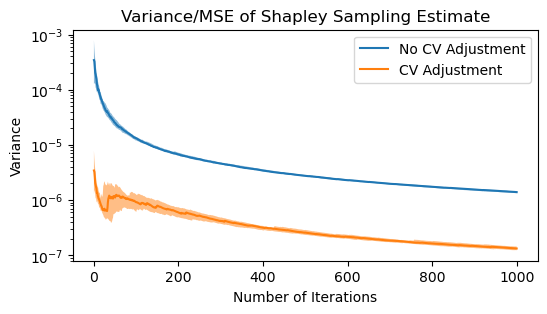

In [13]:
vars_CV_model = np.array(vars_CV_model_all)
vars_CV_25 = np.quantile(vars_CV_model,0.25,axis=0).T
vars_CV_50 = np.quantile(vars_CV_model,0.50,axis=0).T
vars_CV_75 = np.quantile(vars_CV_model,0.75,axis=0).T

vars_vanilla_model = np.array(vars_vanilla_model_all)
vars_vanilla_25 = np.quantile(vars_vanilla_model,0.25,axis=0).T
vars_vanilla_50 = np.quantile(vars_vanilla_model,0.50,axis=0).T
vars_vanilla_75 = np.quantile(vars_vanilla_model,0.75,axis=0).T

start_idx = 0
x = np.arange(start_idx, M)
plt.figure(figsize=(6,3))
plt.plot(x, (vars_vanilla_50[start_idx:]))
plt.plot(x, (vars_CV_50[start_idx:]))
plt.fill_between(x, (vars_vanilla_25[start_idx:]), (vars_vanilla_75[start_idx:]), alpha=0.5)
plt.fill_between(x, (vars_CV_25[start_idx:]), (vars_CV_75[start_idx:]), alpha=0.5)


# plt.title("Variance of Shapley Estimate, Bank Dataset")
plt.title("Variance/MSE of Shapley Sampling Estimate")
plt.yscale("log")
# plt.yticks([10**(-7),10**(-6), 10**(-5)])
plt.legend(["No CV Adjustment", "CV Adjustment"])
plt.xlabel("Number of Iterations")
plt.ylabel("Variance")

plt.show()